# Data Simulator

In [4]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate fixed effects F(x)
def generate_fixed_effects(n, d=9, C=None):
    """
    Generate fixed effects F(x) for n samples.
    
    Parameters:
        n (int): Number of samples.
        d (int): Number of predictor variables (default=9).
        C (float): Scaling constant to adjust variance of F(x) to 1.
    
    Returns:
        F (numpy.ndarray): Fixed effect values of shape (n,).
        X (numpy.ndarray): Predictor variables of shape (n, d).
    """
    X = np.random.normal(0, 1, size=(n, d))  # Generate X ~ N(0, I_d)
    # Define F(x) as given in the problem
    Fx = 2 * X[:, 0] + X[:, 1]**2 + 4 * (X[:, 2] > 0) + 2 * np.log(np.abs(X[:, 0] * X[:, 2]))
    
    if C is None:
        # Calculate C such that var(F(x)) = 1
        C = 1 / np.std(Fx)
    
    F = C * Fx
    return F, X

# Function to generate grouped random effects
def generate_grouped_random_effects(n, m, sigma1_squared=1):
    """
    Generate grouped random effects Zb.

    Parameters:
        n (int): Total number of samples.
        m (int): Number of groups.
        sigma1_squared (float): Variance of random effects.

    Returns:
        Zb (numpy.ndarray): Random effects of shape (n,).
        group_ids (numpy.ndarray): Group IDs for each sample.
    """
    group_ids = np.random.choice(m, size=n)  # Assign each sample to a group
    b = np.random.normal(0, np.sqrt(sigma1_squared), size=m)  # Random effects for each group
    Zb = b[group_ids]  # Assign random effects to each sample
    return Zb, group_ids

# Function to generate spatial Gaussian process random effects
def generate_spatial_gp(n, locations, sigma1_squared=1, rho=0.1):
    """
    Generate spatial Gaussian process random effects Zb.

    Parameters:
        n (int): Number of samples.
        locations (numpy.ndarray): Locations of shape (n, 2).
        sigma1_squared (float): Variance of the Gaussian process.
        rho (float): Range parameter for the exponential covariance function.

    Returns:
        Zb (numpy.ndarray): Spatial random effects of shape (n,).
    """
    # Exponential covariance function
    dists = cdist(locations, locations)
    covariance_matrix = sigma1_squared * np.exp(-dists / rho)
    
    # Simulate random effects from multivariate normal distribution
    Zb = multivariate_normal.rvs(mean=np.zeros(n), cov=covariance_matrix)
    return Zb

# Function to generate data based on the mixed effects model
def generate_data(n, model_type="grouped", m=500, sigma1_squared=1, sigma_squared=1, rho=0.1, locations=None):
    """
    Generate data based on the mixed effects model.

    Parameters:
        n (int): Number of samples.
        model_type (str): Type of random effects model ("grouped" or "spatial").
        m (int): Number of groups (only for grouped random effects).
        sigma1_squared (float): Variance of random effects.
        sigma_squared (float): Variance of error term.
        rho (float): Range parameter for spatial GP (only for spatial model).
        locations (numpy.ndarray): Predefined spatial locations (optional, for spatial model).

    Returns:
        y (numpy.ndarray): Response variable of shape (n,).
        X (numpy.ndarray): Predictor variables of shape (n, 9).
        Zb (numpy.ndarray): Random effects of shape (n,).
        epsilon (numpy.ndarray): Error term of shape (n,).
        group_ids or locations (numpy.ndarray): Group IDs or spatial locations.
    """
    # Generate fixed effects
    F, X = generate_fixed_effects(n)
    
    if model_type == "grouped":
        # Generate grouped random effects
        Zb, group_ids = generate_grouped_random_effects(n, m, sigma1_squared)
        locations_or_groups = group_ids
    elif model_type == "spatial":
        if locations is None:
            raise ValueError("For spatial model, locations must be provided.")
        # Generate spatial random effects
        Zb = generate_spatial_gp(n, locations, sigma1_squared, rho)
        locations_or_groups = locations
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")
    
    # Generate error term
    epsilon = np.random.normal(0, np.sqrt(sigma_squared), size=n)
    
    # Combine to generate response variable y
    y = F + Zb + epsilon
    
    return y, X, Zb, epsilon, locations_or_groups

# Function to generate locations in the specified area
def generate_locations(n, area="train"):
    """
    Generate spatial locations in the specified area.

    Parameters:
        n (int): Number of samples.
        area (str): Area to sample locations from ("train", "interpolation", "extrapolation").

    Returns:
        locations (numpy.ndarray): Locations of shape (n, 2).
    """
    if area == "train" or area == "interpolation":
        # Uniformly sample from [0, 1]^2 excluding [0.5, 1]^2
        locations = []
        while len(locations) < n:
            loc = np.random.uniform(0, 1, size=(n, 2))
            mask = (loc[:, 0] < 0.5) | (loc[:, 1] < 0.5)  # Exclude [0.5, 1]^2
            locations.extend(loc[mask])
        locations = np.array(locations[:n])
    elif area == "extrapolation":
        # Uniformly sample from [0.5, 1]^2
        locations = np.random.uniform(0.5, 1, size=(n, 2))
    else:
        raise ValueError("Invalid area. Choose from 'train', 'interpolation', or 'extrapolation'.")
    
    return locations

# Function to generate training and test datasets
def generate_train_test_data(n_train, n_test, model_type, m=500, sigma1_squared=1, sigma_squared=1, rho=0.1):
    """
    Generate training and test datasets (interpolation and extrapolation).

    Parameters:
        n_train (int): Number of training samples.
        n_test (int): Number of test samples.
        model_type (str): Type of random effects model ("grouped" or "spatial").
        m (int): Number of groups (only for grouped random effects).
        sigma1_squared (float): Variance of random effects.
        sigma_squared (float): Variance of error term.
        rho (float): Range parameter for spatial GP (only for spatial model).

    Returns:
        train_data (dict): Training data.
        test_data_interpolation (dict): Interpolation test data.
        test_data_extrapolation (dict): Extrapolation test data.
    """
    if model_type == "spatial":
        # Generate locations for training and test datasets
        train_locations = generate_locations(n_train, area="train")
        interp_locations = generate_locations(n_test, area="interpolation")
        extrap_locations = generate_locations(n_test, area="extrapolation")
        
        # Generate training data
        train_data = generate_data(n_train, model_type, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared, rho=rho, locations=train_locations)
        
        # Generate interpolation test data
        test_data_interpolation = generate_data(n_test, model_type, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared, rho=rho, locations=interp_locations)
        
        # Generate extrapolation test data
        test_data_extrapolation = generate_data(n_test, model_type, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared, rho=rho, locations=extrap_locations)
    else:
        # Generate grouped random effects data
        train_data = generate_data(n_train, model_type, m=m, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared)
        test_data_interpolation = generate_data(n_test, model_type, m=m, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared)
        test_data_extrapolation = generate_data(n_test, model_type, m=m, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared)
    
    return train_data, test_data_interpolation, test_data_extrapolation

# Example usage for spatial model
n_train = 500  # Training sample size
n_test = 500   # Test sample size

train_spatial, test_interp_spatial, test_extrap_spatial = generate_train_test_data(
    n_train, n_test, model_type="spatial", sigma1_squared=1, sigma_squared=1, rho=0.1
)



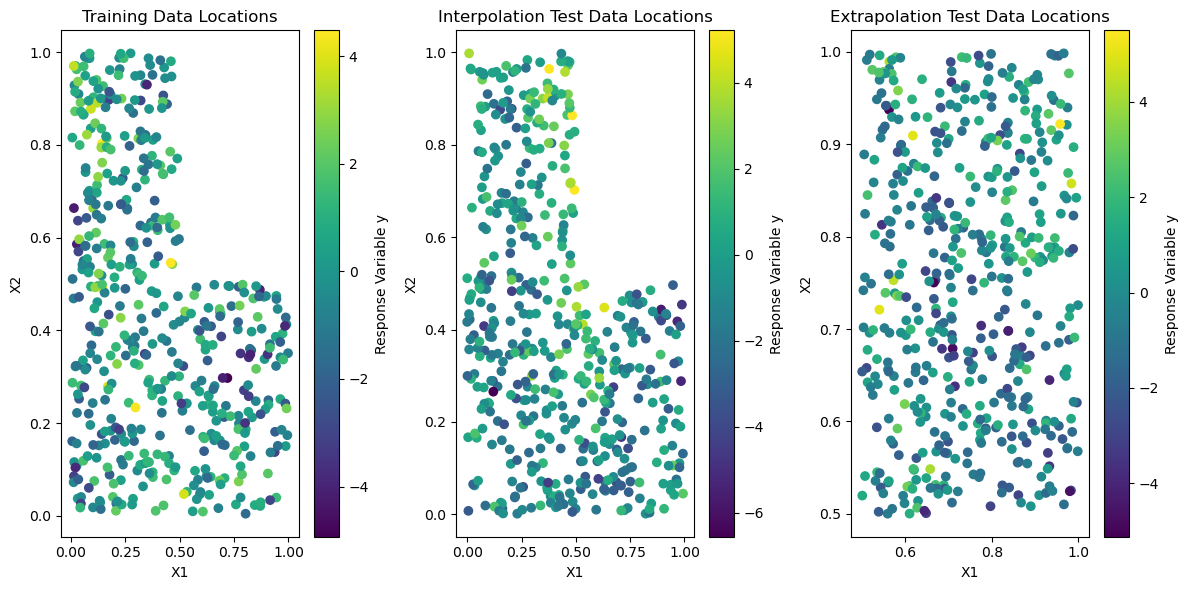

In [5]:
import matplotlib.pyplot as plt

# Extract locations and response variable y from the generated data
train_locations = train_spatial[4]
train_y = train_spatial[0]

interp_locations = test_interp_spatial[4]
interp_y = test_interp_spatial[0]

extrap_locations = test_extrap_spatial[4]
extrap_y = test_extrap_spatial[0]

# Plot the training data locations
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(train_locations[:, 0], train_locations[:, 1], c=train_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Training Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

# Plot the interpolation test data locations
plt.subplot(1, 3, 2)
plt.scatter(interp_locations[:, 0], interp_locations[:, 1], c=interp_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Interpolation Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

# Plot the extrapolation test data locations
plt.subplot(1, 3, 3)
plt.scatter(extrap_locations[:, 0], extrap_locations[:, 1], c=extrap_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Extrapolation Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()
plt.show()

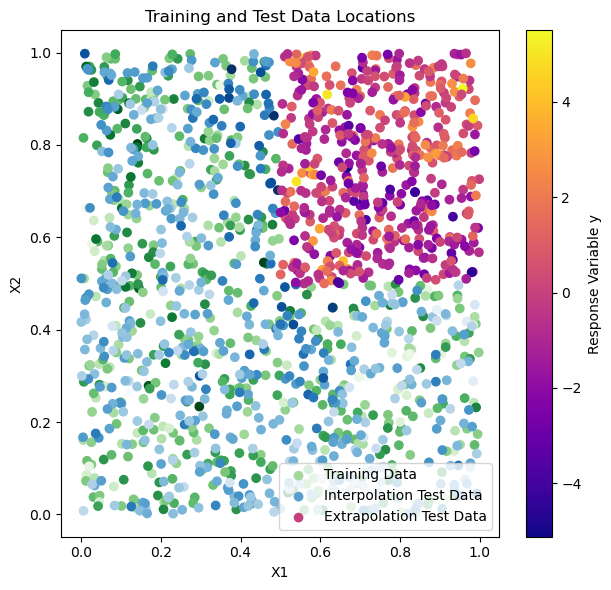

In [32]:
import matplotlib.pyplot as plt

# Extract locations and response variable y from the generated data
train_locations = train_spatial[4]
train_y = train_spatial[0]

interp_locations = test_interp_spatial[4]
interp_y = test_interp_spatial[0]

extrap_locations = test_extrap_spatial[4]
extrap_y = test_extrap_spatial[0]

# Plot the training data locations with interpolation test data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_locations[:, 0], train_locations[:, 1], c=train_y, cmap='Greens', marker='o', label='Training Data')
plt.scatter(interp_locations[:, 0], interp_locations[:, 1], c=interp_y, cmap='Blues', marker='o', label='Interpolation Test Data')
plt.scatter(extrap_locations[:, 0], extrap_locations[:, 1], c=extrap_y, cmap='plasma', marker='o', label='Extrapolation Test Data')
plt.colorbar(label='Response Variable y')
plt.title('Training and Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()

# # Plot the training data locations with extrapolation test data
# plt.subplot(1, 2, 2)
# plt.scatter(train_locations[:, 0], train_locations[:, 1], c=train_y, cmap='viridis', marker='o', label='Training Data')
# plt.scatter(extrap_locations[:, 0], extrap_locations[:, 1], c=extrap_y, cmap='plasma', marker='o', label='Extrapolation Test Data')
# plt.colorbar(label='Response Variable y')
# plt.title('Training + Extrapolation Test Data Locations')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()

plt.tight_layout()
plt.show()